In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline

In [2]:
data = pd.read_csv("D:/AI Data Science/Dataset/customers.csv")
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax
    

def channel_results(reduced_data, outliers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
	Data is labeled by "Channel" and cues added for student-selected sample data
	'''

	# Check that the dataset is loadable
	try:
	    full_data = pd.read_csv("D:/AI Data Science/Dataset/customers.csv")
	except:
	    print("Dataset could not be loaded. Is the file missing?")       
	    return False

	# Create the Channel DataFrame
	channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
	channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
	labeled = pd.concat([reduced_data, channel], axis = 1)
	
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned Channel
	labels = ['Hotel/Restaurant/Cafe', 'Retailer']
	grouped = labeled.groupby('Channel')
	for i, channel in grouped:   
	    channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
	    
	# Plot transformed sample points   
	for i, sample in enumerate(pca_samples):
		ax.scatter(x = sample[0], y = sample[1], \
	           s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
		ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

	# Set plot title
	ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

In [5]:
# Print some sample data
display(data.head())

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
# Display Data Info
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicatessen      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


None

In [7]:
# Display a description of the dataset
display(data.describe())

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [8]:
# Select three indices of your choice you wish to sample from the dataset
np.random.seed(2018)
indices = np.random.randint(low = 0, high = 441, size = 3)
print("Indices of Samples => {}".format(indices))

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("\nChosen samples of wholesale customers dataset:")
display(samples)

Indices of Samples => [250 102 226]

Chosen samples of wholesale customers dataset:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,1,3191,1993,1799,1730,234,710
1,2,3,2932,6459,7677,2561,4573,1386
2,2,1,20782,5921,9212,1759,2568,1553


In [9]:
# Function to display the sample data vs the population mean for
# each of the categories
def sampl_pop_plotting(sample):
    fig, ax = plt.subplots(figsize=(10,5))
    
    index = np.arange(sample.count())
    bar_width = 0.3
    opacity_pop = 1
    opacity_sample = 0.3

    rect1 = ax.bar(index, data.mean(), bar_width,
                    alpha=opacity_pop, color='g',
                    label='Population Mean')
    
    rect2 = ax.bar(index + bar_width, sample, bar_width,
                    alpha=opacity_sample, color='k',
                    label='Sample')
    
    ax.set_xlabel('Categories')
    ax.set_ylabel('Total Purchase Cost')
    ax.set_title('Sample vs Population Mean')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(samples.columns)
    ax.legend(loc=0, prop={'size': 15})
    
    fig.tight_layout()
    plt.show()

In [10]:
# Display data for the first sample wrt to the population mean
display(samples.iloc[0] - data.mean())

Channel               -0.322727
Region                -1.543182
Fresh              -8809.297727
Milk               -3803.265909
Grocery            -6152.277273
Frozen             -1341.931818
Detergents_Paper   -2647.493182
Delicatessen        -814.870455
dtype: float64

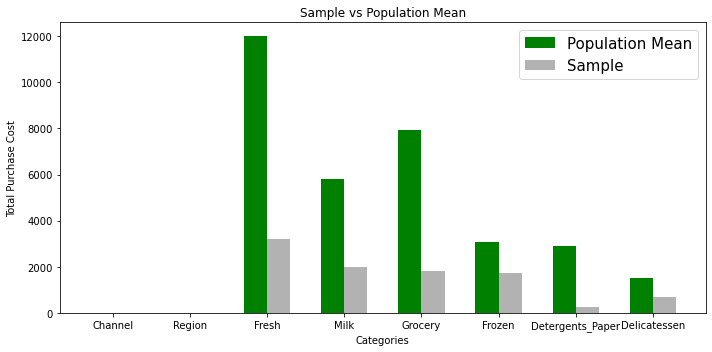

In [11]:
# Plot data for the first sample wrt to the population mean
sampl_pop_plotting(samples.iloc[0])

In [12]:
# Display data for the second sample wrt to the population mean
display(samples.iloc[1] - data.mean())

Channel                0.677273
Region                 0.456818
Fresh              -9068.297727
Milk                 662.734091
Grocery             -274.277273
Frozen              -510.931818
Detergents_Paper    1691.506818
Delicatessen        -138.870455
dtype: float64

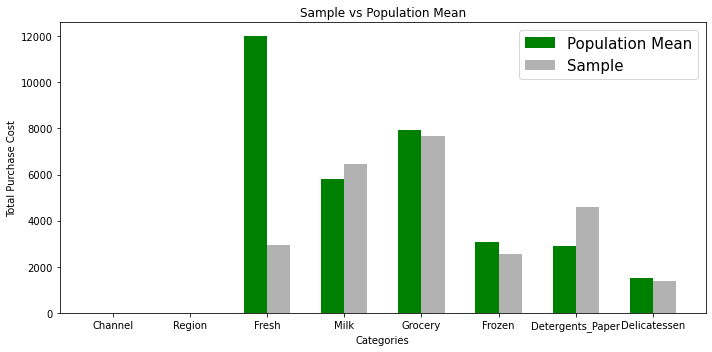

In [13]:
# Plot data for the second sample wrt to the population mean
sampl_pop_plotting(samples.iloc[1])

In [15]:
#Display data for the third sample wrt to the population mean
display(samples.iloc[2] - data.mean())

Channel                0.677273
Region                -1.543182
Fresh               8781.702273
Milk                 124.734091
Grocery             1260.722727
Frozen             -1312.931818
Detergents_Paper    -313.493182
Delicatessen          28.129545
dtype: float64

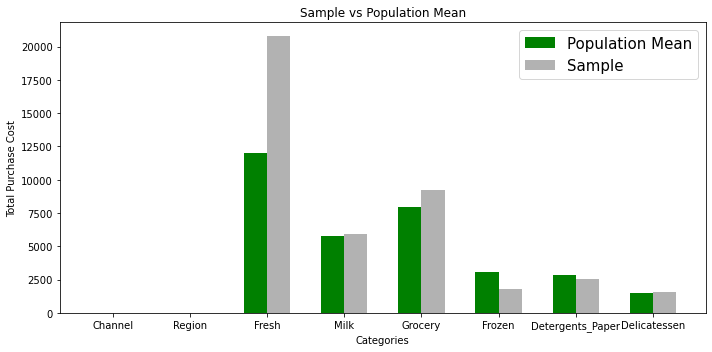

In [16]:
# Plot data for the third sample wrt to the population mean
sampl_pop_plotting(samples.iloc[2])

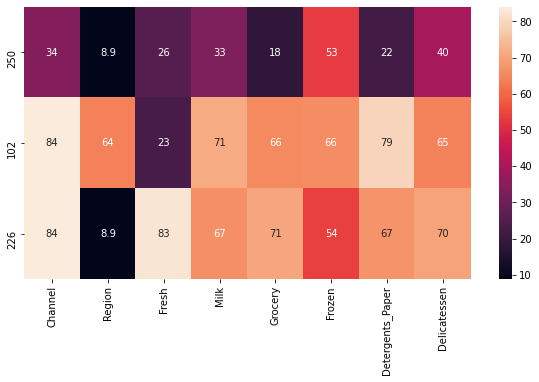

In [17]:
# percentile heatmap for sample points
percentiles_data = 100*data.rank(pct=True)
percentiles_samples = percentiles_data.iloc[indices]
plt.subplots(figsize=(10,5))
_ = sns.heatmap(percentiles_samples, annot=True)

In [18]:
def predict_one_feature(dropped_feature):
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    print("Dropping feature -> {}".format(dropped_feature))
    new_data = data.drop([dropped_feature], axis = 1)
    
    # Split the data into training and testing sets(0.25) using the given feature as the target
    # Set a random state.
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[dropped_feature], test_size=0.25, random_state=0)
    
    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)
    
    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("Score for predicting '{}' using other features = {:.3f}\n".format(dropped_feature, score))

In [19]:
# Attempt to predict the score of 'Milk' using other features
predict_one_feature('Milk')

Dropping feature -> Milk
Score for predicting 'Milk' using other features = 0.198



In [20]:
print("Features in data -> {}\n".format(data.columns.values))

# Predict the score of each feature by dropping it and using other features
for cols in data.columns.values:
    predict_one_feature(cols)

Features in data -> ['Channel' 'Region' 'Fresh' 'Milk' 'Grocery' 'Frozen' 'Detergents_Paper'
 'Delicatessen']

Dropping feature -> Channel
Score for predicting 'Channel' using other features = 0.293

Dropping feature -> Region
Score for predicting 'Region' using other features = -0.840

Dropping feature -> Fresh
Score for predicting 'Fresh' using other features = -0.414

Dropping feature -> Milk
Score for predicting 'Milk' using other features = 0.198

Dropping feature -> Grocery
Score for predicting 'Grocery' using other features = 0.661

Dropping feature -> Frozen
Score for predicting 'Frozen' using other features = 0.264

Dropping feature -> Detergents_Paper
Score for predicting 'Detergents_Paper' using other features = 0.678

Dropping feature -> Delicatessen
Score for predicting 'Delicatessen' using other features = -11.584



No handles with labels found to put in legend.


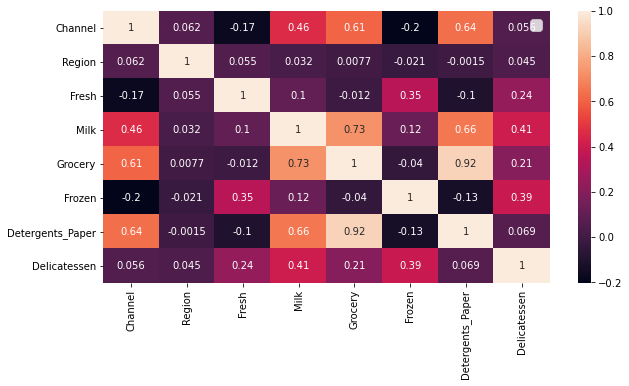

In [21]:
# Display the correlation heatmap
corr = data.corr()

plt.figure(figsize = (10,5))
ax = sns.heatmap(corr, annot=True)
ax.legend(loc=0, prop={'size': 15})

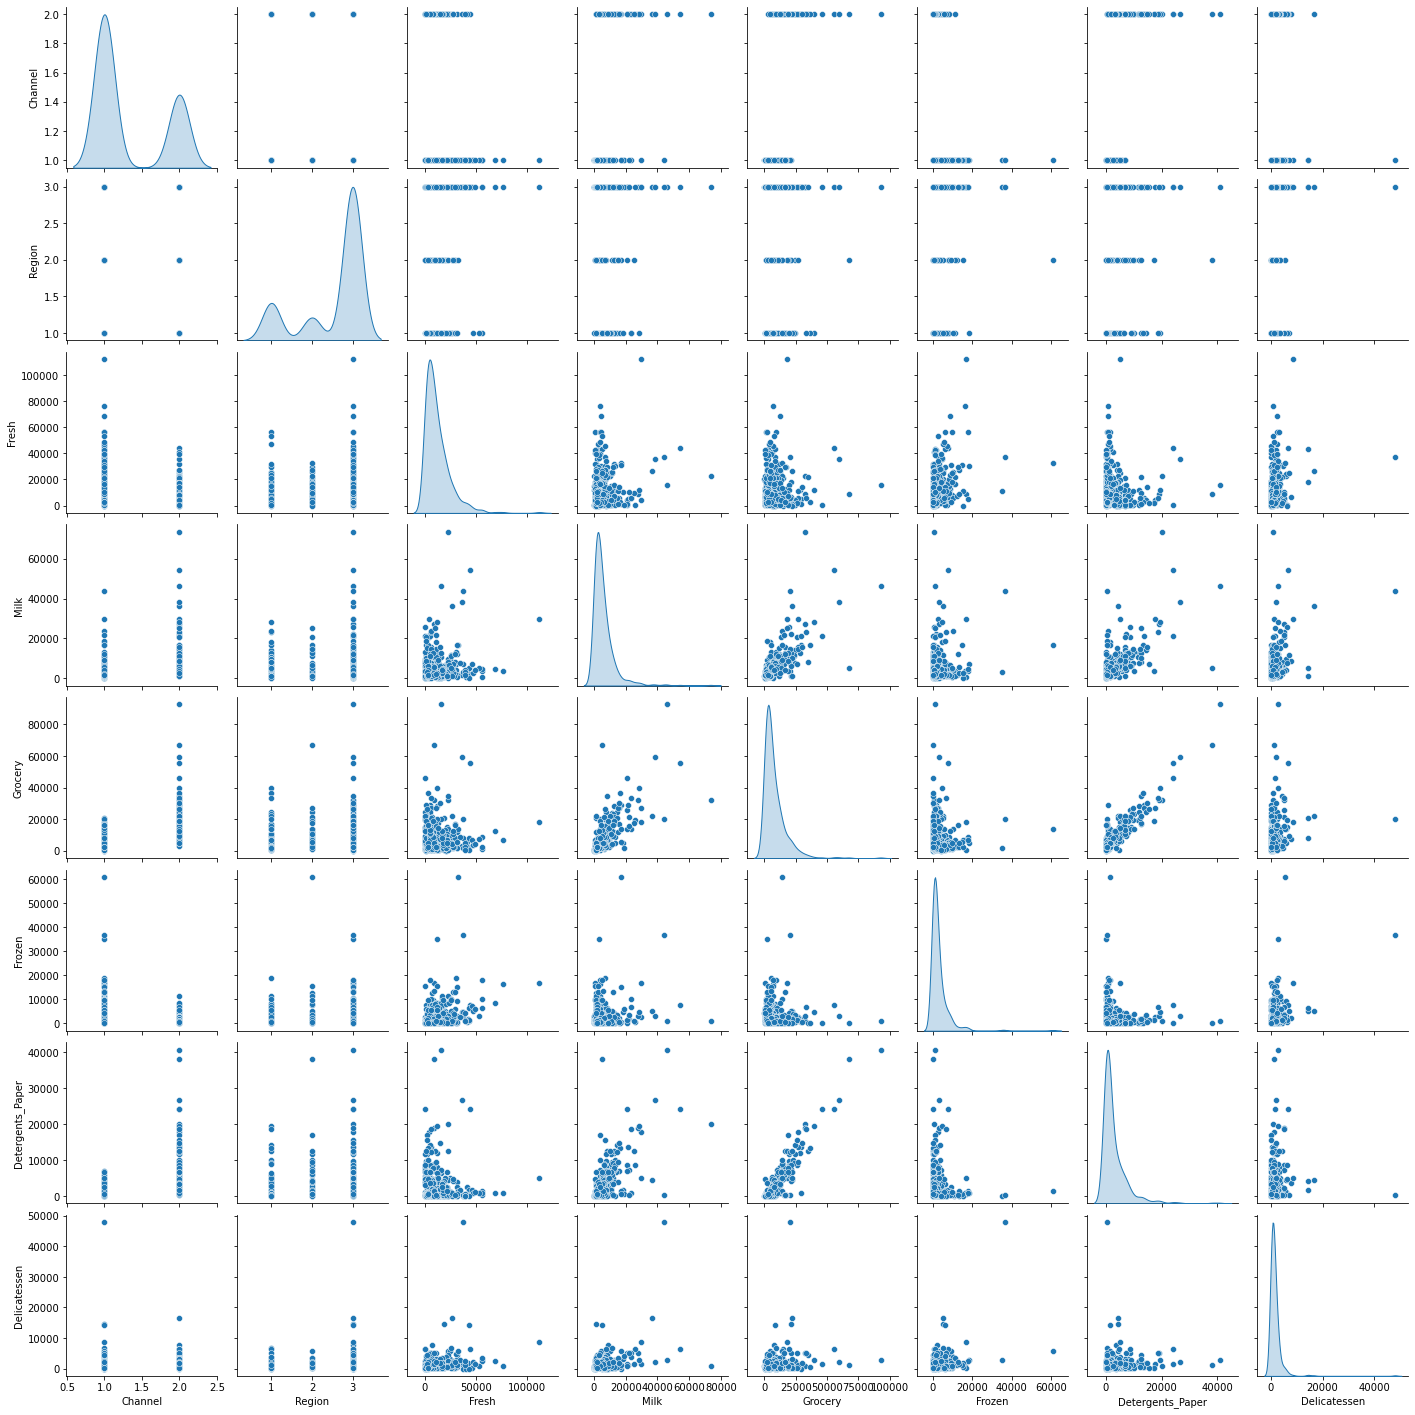

In [22]:
# Produce a scatter matrix for each pair of features in the data
_ = sns.pairplot(data, diag_kind = 'kde')

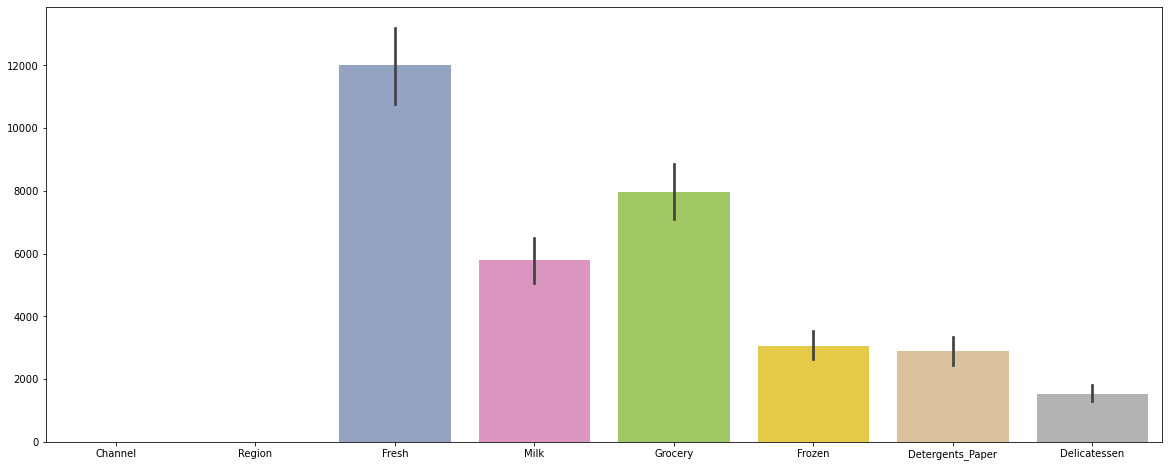

In [23]:
plt.figure(figsize = (20,8))
_ = sns.barplot(data=data, palette="Set2")

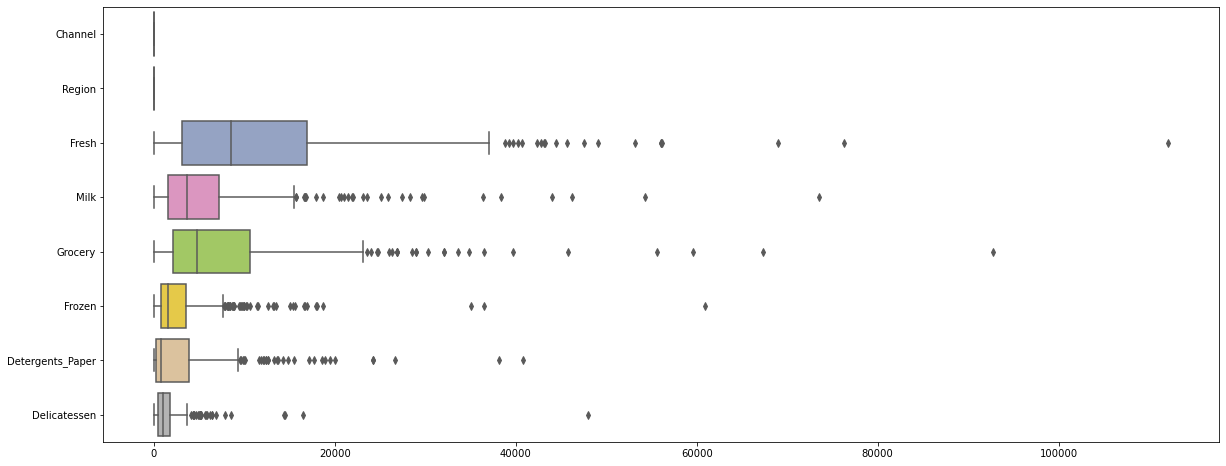

In [24]:
plt.figure(figsize = (20,8))
_ = sns.boxplot(data=data, orient='h', palette="Set2")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


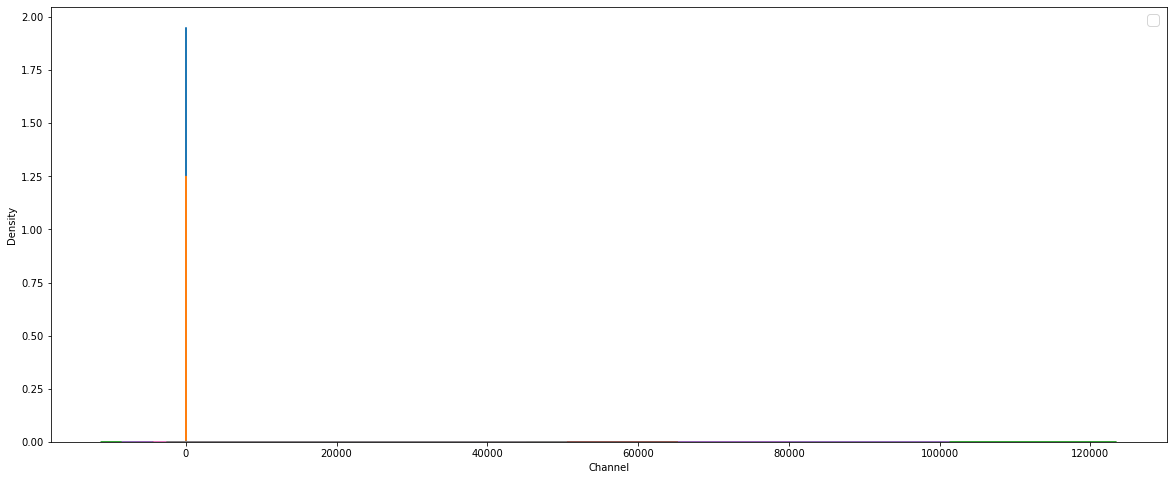

In [25]:
plt.figure(figsize = (20,8))

for cols in data.columns.values:
    ax = sns.kdeplot(data[cols])
    ax.legend(loc=0, prop={'size': 15})

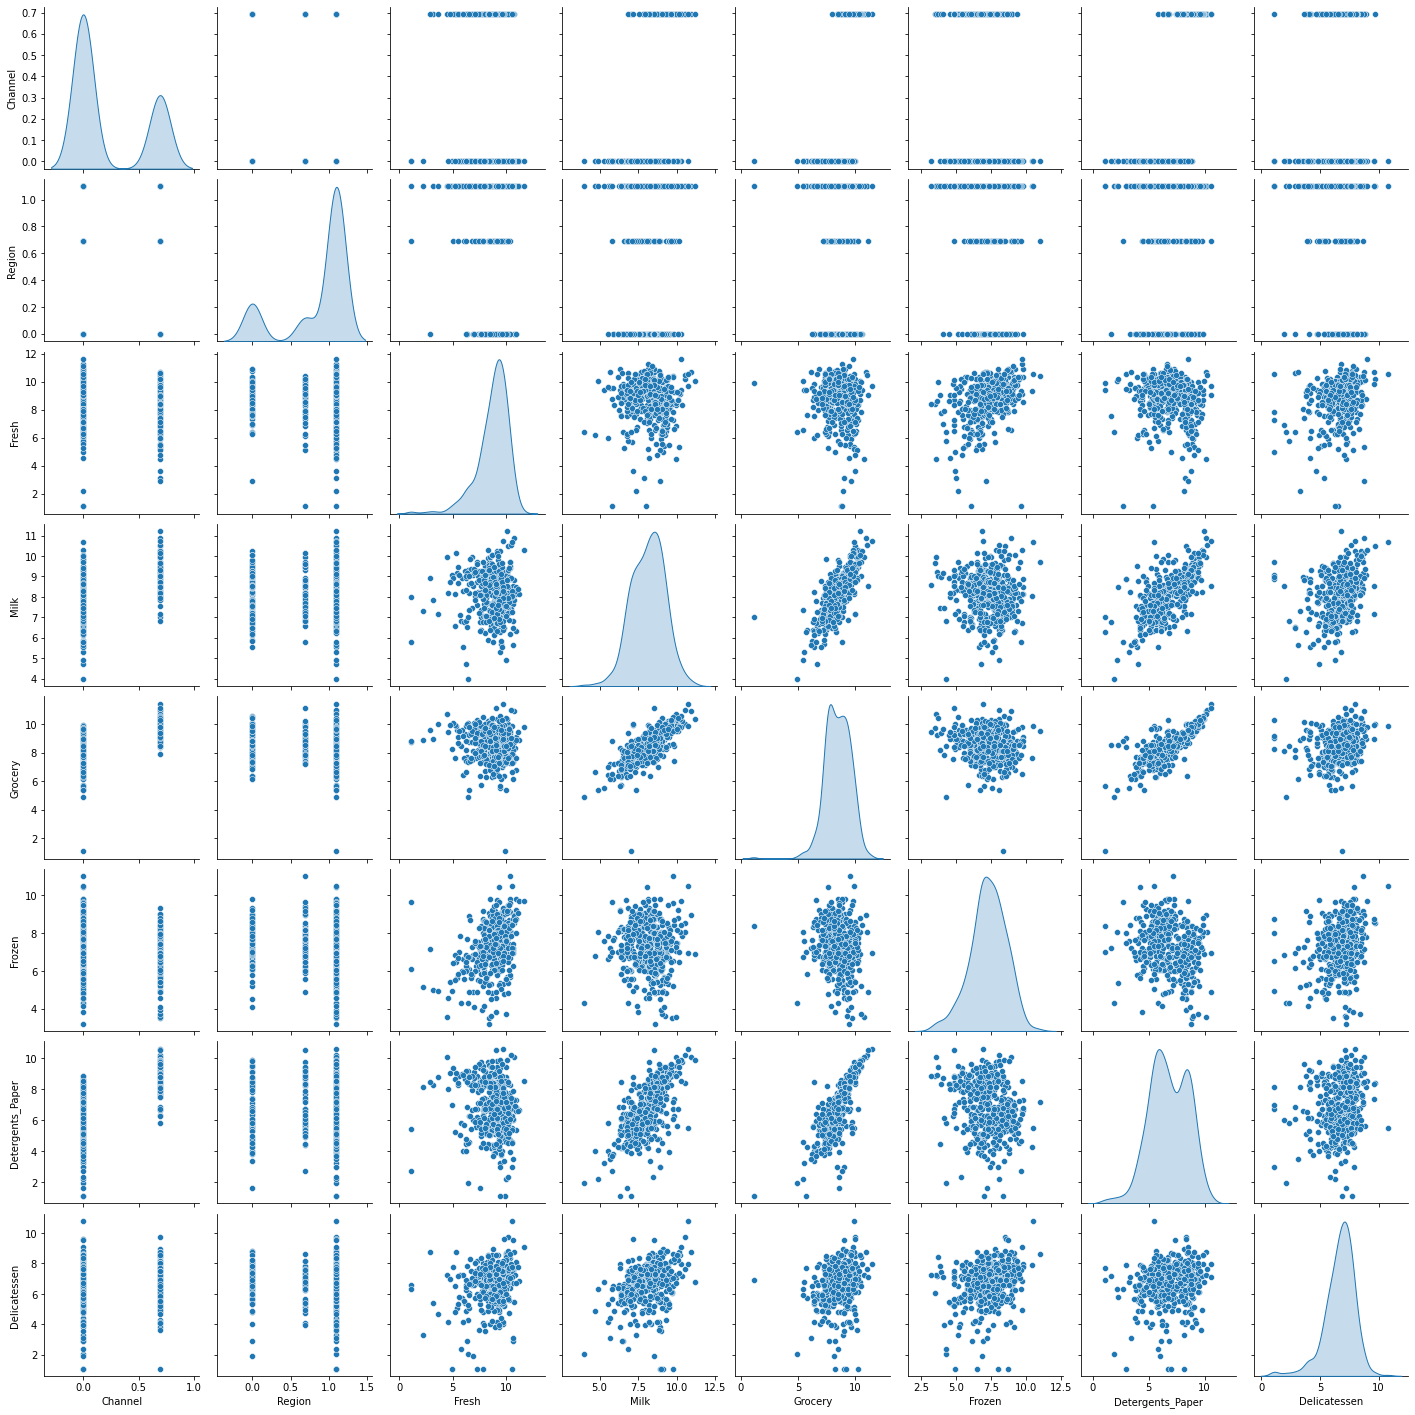

In [27]:
#Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
_ = sns.pairplot(log_data, diag_kind = 'kde')

In [28]:
# Display the log-transformed sample data
display(log_samples)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.000000,0.000000,8.068090,7.597396,7.494986,7.455877,5.455321,6.565265
1,0.693147,1.098612,7.983440,8.773230,8.945984,7.848153,8.427925,7.234177
2,0.693147,0.000000,9.941843,8.686261,9.128262,7.472501,7.850883,7.347944


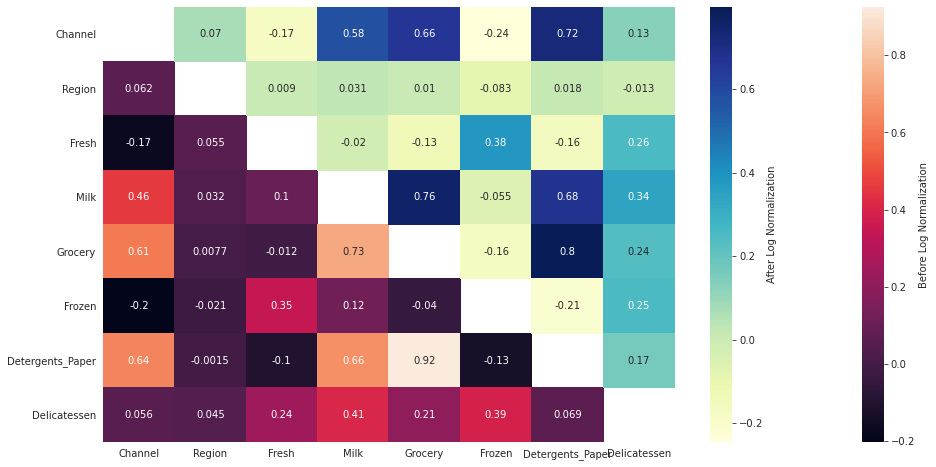

In [29]:
# Display the correlation heatmap
log_corr = log_data.corr()

f = plt.figure(figsize = (16,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(corr, annot=True, mask=mask, cbar_kws={'label': 'Before Log Normalization'})

mask2 = np.zeros_like(corr)
mask2[np.tril_indices_from(mask2)] = True
with sns.axes_style("white"):
    ax2 = sns.heatmap(log_corr, annot=True, mask=mask2, cmap="YlGnBu", cbar_kws={'label': 'After Log Normalization'})

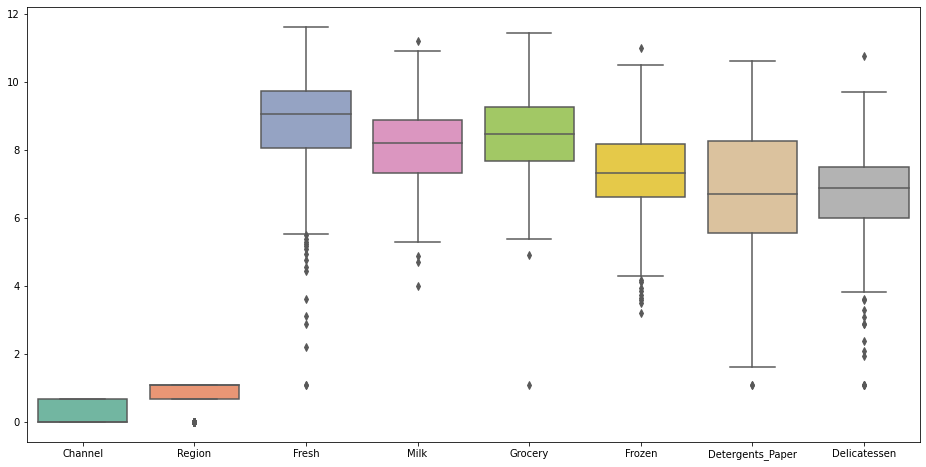

In [30]:
# boxplot on the logdata
plt.figure(figsize = (16,8))
_ = sns.boxplot(data=log_data, palette="Set2")

# Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:

Assign the value of the 25th percentile for the given feature to Q1. Use np.percentile for this.
Assign the value of the 75th percentile for the given feature to Q3. Again, use np.percentile.
Assign the calculation of an outlier step for the given feature to step.
Optionally remove data points from the dataset by adding indices to the outliers list.
NOTE: If you choose to remove any outliers, ensure that the sample data does not contain any of these points!
Once you have performed this implementation, the dataset will be stored in the variable good_data.

In [31]:
outliers_list = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    outliers = list(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.values)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outliers_list.extend(outliers)
    
print("List of Outliers -> {}".format(outliers_list))
duplicate_outliers_list = list(set([x for x in outliers_list if outliers_list.count(x) >= 2]))
duplicate_outliers_list.sort()
print("\nList of Common Outliers -> {}".format(duplicate_outliers_list))

# Select the indices for data points you wish to remove
outliers  = duplicate_outliers_list

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Channel':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Data points considered outliers for the feature 'Region':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
196,0.000000,0.0,10.329539,8.883086,8.496378,9.836867,6.637258,7.964156
197,0.693147,0.0,7.794411,8.867427,9.248695,7.027315,8.369621,7.291656
198,0.000000,0.0,9.366147,7.675082,8.828201,8.168203,6.383507,6.546785
199,0.000000,0.0,9.176784,7.731931,7.655391,6.253829,5.996452,5.849325
200,0.693147,0.0,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413
...,...,...,...,...,...,...,...,...
268,0.693147,0.0,9.384966,8.993800,9.895808,6.974479,8.759982,6.548219
269,0.000000,0.0,9.630234,5.552960,7.037028,7.830426,5.808142,5.318120
270,0.000000,0.0,8.459564,6.939254,6.882437,8.612503,5.283204,4.025352
271,0.000000,0.0,7.641564,8.518592,7.354362,7.021084,4.990433,7.346010


Data points considered outliers for the feature 'Fresh':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,0.693147,1.098612,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,0.000000,1.098612,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,0.693147,1.098612,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,0.000000,1.098612,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,0.693147,1.098612,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,0.000000,1.098612,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,0.693147,1.098612,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,0.693147,1.098612,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,0.693147,0.000000,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,0.693147,0.693147,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,0.693147,1.098612,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,0.000000,1.098612,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,0.000000,1.098612,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,0.000000,1.098612,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,0.0,1.098612,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,0.0,1.098612,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,0.693147,1.098612,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,0.693147,1.098612,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,0.693147,1.098612,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,0.693147,1.098612,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,0.693147,1.098612,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,0.693147,0.000000,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,0.000000,0.693147,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,0.000000,1.098612,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,0.000000,1.098612,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,0.000000,1.098612,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,0.0,1.098612,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,0.0,1.098612,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,0.000000,1.098612,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,0.693147,1.098612,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,0.000000,1.098612,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,0.000000,1.098612,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,0.000000,1.098612,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,0.000000,1.098612,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,0.000000,1.098612,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,0.000000,1.098612,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,0.000000,1.098612,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,0.000000,0.000000,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


List of Outliers -> [196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 154, 356, 75, 154, 38, 57, 65, 145, 175, 264, 325, 420, 429, 439, 75, 161, 66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]

List of Common Outliers -> [65, 66, 75, 128, 154, 203, 218, 233, 264]


Explained Variance Ratio => [0.44331391 0.25295288 0.11681015 0.0984037  0.04778731 0.02041274]

Explained Variance Ratio(csum) => [0.44331391 0.69626679 0.81307694 0.91148064 0.95926795 0.97968068]



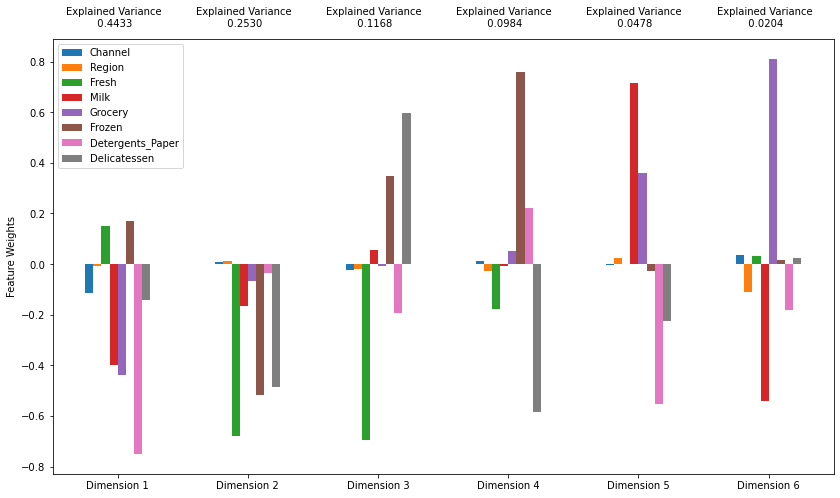

In [32]:
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6, random_state=0)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)
print("Explained Variance Ratio => {}\n".format(pca.explained_variance_ratio_))
print("Explained Variance Ratio(csum) => {}\n".format(pca.explained_variance_ratio_.cumsum()))

# Generate PCA results plot
pca_results = pca_results(good_data, pca)

In [33]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.6007,0.6899,0.7197,-0.0134,0.0227,-0.1847
1,-1.8645,-0.1622,0.7561,0.6076,-0.3987,-0.2635
2,-1.2525,-1.3467,-0.5382,-0.1820,-0.1162,0.2155


In [34]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2, random_state=0)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [35]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.6007,0.6899
1,-1.8645,-0.1622
2,-1.2525,-1.3467


<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

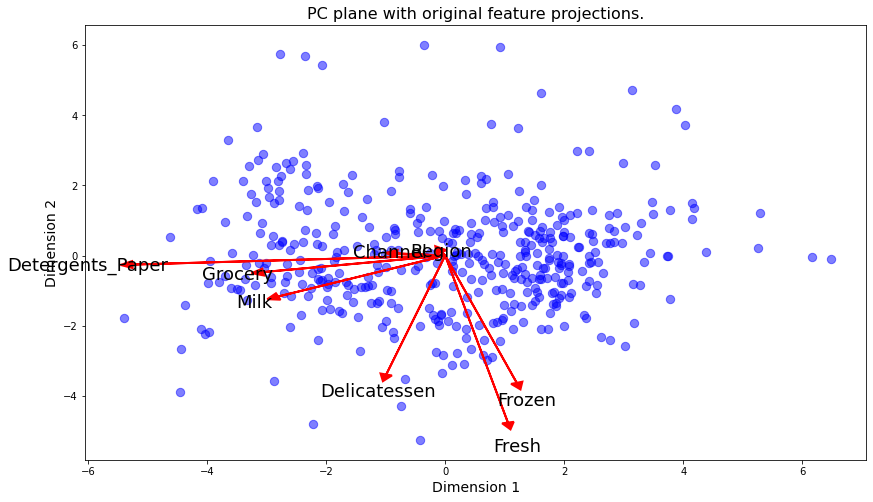

In [36]:
# Create a biplot
biplot(good_data, reduced_data, pca)

In [37]:
def sil_coeff(no_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer_1 = KMeans(n_clusters=no_clusters, random_state=0 )
    clusterer_1.fit(reduced_data)
    
    # Predict the cluster for each data point
    preds_1 = clusterer_1.predict(reduced_data)
    
    # Find the cluster centers
    centers_1 = clusterer_1.cluster_centers_
    
    # Predict the cluster for each transformed sample data point
    sample_preds_1 = clusterer_1.predict(pca_samples)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds_1)
    
    print("silhouette coefficient for `{}` clusters => {:.4f}".format(no_clusters, score))
    
clusters_range = range(2,15)
for i in clusters_range:
    sil_coeff(i)

silhouette coefficient for `2` clusters => 0.4333
silhouette coefficient for `3` clusters => 0.3908
silhouette coefficient for `4` clusters => 0.3339
silhouette coefficient for `5` clusters => 0.3510
silhouette coefficient for `6` clusters => 0.3530
silhouette coefficient for `7` clusters => 0.3614
silhouette coefficient for `8` clusters => 0.3505
silhouette coefficient for `9` clusters => 0.3507
silhouette coefficient for `10` clusters => 0.3723
silhouette coefficient for `11` clusters => 0.3618
silhouette coefficient for `12` clusters => 0.3467
silhouette coefficient for `13` clusters => 0.3614
silhouette coefficient for `14` clusters => 0.3694


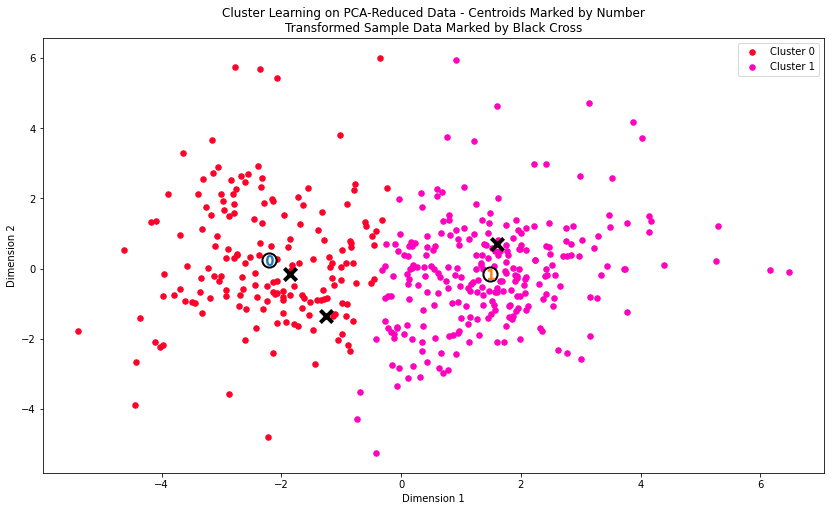

In [38]:
# Display the results of the clustering from implementation for 2 clusters
clusterer = KMeans(n_clusters = 2)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples)

cluster_results(reduced_data, preds, centers, pca_samples)

In [39]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,2.0,2.0,4043.0,7887.0,12161.0,932.0,4634.0,1001.0
Segment 1,1.0,2.0,9162.0,1919.0,2493.0,2145.0,295.0,716.0


In [40]:
display(data.mean(axis=0))

Channel                 1.322727
Region                  2.543182
Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64

In [41]:
display(samples)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,1,3191,1993,1799,1730,234,710
1,2,3,2932,6459,7677,2561,4573,1386
2,2,1,20782,5921,9212,1759,2568,1553


In [42]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


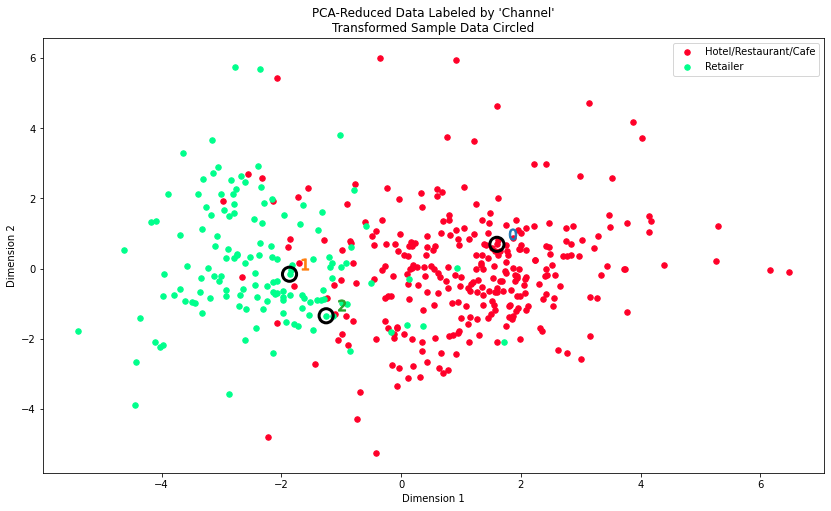

In [43]:
# Display the clustering results based on 'Channel' data
channel_results(reduced_data, outliers, pca_samples)